# 个人3C产品精准营销案例

## 背景:一家著名3C产品制造商于2013年年底在推出一款新产品，经过一段时间运营发现其销售状况不理想。因此该公司希望通过已有销售数据来挖掘该产品的受众群，进而进行精准营销。该数据的销售数据包括大约40000个样本和16个各种属性变量，其中包括是否购买过该产品，购买者的个人信息如性别、年龄、教育背景等，具体变量如表所示，其中ID是客户唯一识别信息(ID)

|变量名|变量说明|
|:--:|:--:|
|ID	|数据库中每个人的ID|
|target_flag|	是否购买过目标产品|
|gender|	性别|
|education	|教育背景|
|home_value|	所住房屋的价值|
|age	|年龄信息，以类似25-35分组表示|
|buy_online	|有无网购记录|
|mosaic_group	|根据居住区域归纳的描述消费心理的变量|
|marital	|婚姻状态|
|poc	|有无小孩|
|occupation	|职业信息|
|mortgage	|住房贷款信息|
|home_owner	|所住房屋是否自有|
|region	|所处地区信息|
|new_car|	购买新车的可能性（1代表最可能）|
|home_income|	家庭收入信息（A代表最低，L代表最高）|

### 读取数据，并对数据进行初步探索

In [183]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

In [184]:
train = pd.read_csv('response_data_train.csv', skipinitialspace=True)
test = pd.read_csv('response_data_test.csv', skipinitialspace=True)
print(train.shape)
print(test.shape)

(30000, 15)
(10000, 15)


In [185]:
train.describe(include='all')

,target_flag,gender,education,home_value,age,buy_online,mosaic_group,marital,poc,occupation,mortgage,home_owner,region,new_car,home_income
count,30000,30000,29455,3.000000e+04,30000,30000,30000,19519,30000,30000,30000,27461,30000,30000.000000,30000
unique,2,3,5,NaN,7,2,11,2,4,6,3,2,5,NaN,13
top,N,M,2. Some College,NaN,5_<=55,Y,B,Married,Y,Professional,1Low,Owner,South,NaN,E
freq,15005,16522,8559,NaN,6054,20533,6251,15722,13449,11232,22365,21963,11759,NaN,6285
mean,NaN,NaN,NaN,3.079385e+05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.481000,NaN
std,NaN,NaN,NaN,4.255385e+05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.573116,NaN
min,NaN,NaN,NaN,0.000000e+00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN
25%,NaN,NaN,NaN,8.163175e+04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,NaN
50%,NaN,NaN,NaN,2.146915e+05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.000000,NaN
75%,NaN,NaN,NaN,3.945250e+05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.000000,NaN


In [186]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 15 columns):
target_flag     30000 non-null object
gender          30000 non-null object
education       29455 non-null object
home_value      30000 non-null int64
age             30000 non-null object
buy_online      30000 non-null object
mosaic_group    30000 non-null object
marital         19519 non-null object
poc             30000 non-null object
occupation      30000 non-null object
mortgage        30000 non-null object
home_owner      27461 non-null object
region          30000 non-null object
new_car         30000 non-null int64
home_income     30000 non-null object
dtypes: int64(2), object(13)
memory usage: 1.9+ MB


In [187]:
#为了方便后续处理,我们将变量划分为连续变量和离散变量

cols = train.columns.tolist()
x_c = ['home_value', 'new_car']
x_d = list(set(cols) - set(x_c)); 
x_d.remove('target_flag')

### 数据预处理

#### 编码同时填补缺失值

In [188]:
#自定义一个编码函数
def label_encoder(series):
    cat = series.value_counts(dropna=False)
    len_series = len(series)
    return {k:v for k, v in zip(cat.index, range(len_series))}

#对所有的离散型解释变量进行编码,其中测试集的编码方式要与训练集的一致
for col in x_d:
    encoder = label_encoder(train[col])
    train[col].replace(encoder, inplace=True)  # Encode train
    test[col].replace(encoder, inplace=True)  # Encode test
    
    
#被解释变量也需要通过类型转换
encoder=label_encoder(train.target_flag)
train.target_flag.replace(encoder,inplace=True)
test.target_flag.replace(encoder,inplace=True)

#### WOE编码（或哑变量变换）；sklearn中的决策树算法默认所有输入变量作为连续变量处理，因此对于分类变量，需要进行WOE转换。鉴于此，可以将所有变量统一作WOE转换

Jupyter中引入包，只要包放在同一个文件加下即可

In [189]:
from woe import WoE

for col in x_d:
    woe=WoE(v_type='d',t_type='b')
    woe.fit(train[col],train.target_flag)
    train[col]=woe.transform(train[col])['woe']
    test[col]=woe.transform(test[col])['woe']


In [190]:
train.head()

,target_flag,gender,education,home_value,age,buy_online,mosaic_group,marital,poc,occupation,mortgage,home_owner,region,new_car,home_income
0,1,0.388459,0.654383,756460,-0.489924,-0.645624,0.496589,-0.423279,0.024719,0.602608,-0.26241,-0.251948,-0.147533,1,0.922591
1,0,-0.443879,0.513493,213171,-0.670878,-0.645624,-0.018658,-0.423279,0.024719,0.602608,-0.26241,0.157707,0.032415,3,0.367741
2,0,0.388459,-0.028077,111147,-0.740683,0.289713,0.755544,-0.423279,0.111867,0.602608,-0.26241,0.157707,-0.147533,1,0.882186
3,1,0.388459,-0.028077,354151,-0.740683,0.289713,0.496589,-0.169880,0.024719,-0.249091,-0.26241,-0.251948,0.087040,2,0.922591
4,1,-0.443879,-0.028077,117087,-0.489924,0.289713,-0.742657,0.321675,0.111867,-0.249091,-0.26241,-0.251948,0.006279,7,0.496493


### 建模

在没有进行变量筛选的情况下，通过搜索参数网格，选择模型的最优超参

In [191]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

dt=DecisionTreeClassifier()
grid={
    'max_leaf_nodes':np.arange(32,64,6),
    'min_samples_split':np.arange(50,301,50)
}
cv=GridSearchCV(dt,grid,scoring='roc_auc',cv=4,n_jobs=-1)
cv.fit(train.ix[:,1:],train['target_flag'])

print('best_score:%2.4f' %cv.best_score_)
print('best_params： %s' %cv.best_params_)

best_score:0.7405
best_params： {'max_leaf_nodes': 56, 'min_samples_split': 50}


In [192]:
#查看模型在测试集上的表现

from sklearn.metrics import roc_auc_score, roc_curve

test_p = cv.predict_proba(test.ix[:, 1:])
print(roc_auc_score(test.target_flag, test_p[:, 1]))

0.7376618176618177


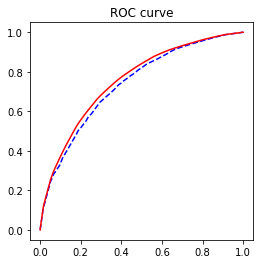

In [193]:
#模型评估（模型的过拟合情况不太严重）
train_p = cv.predict_proba(train.ix[:, 1:])
test_p = cv.predict_proba(test.ix[:, 1:])
fpr_test, tpr_test, th_test = roc_curve(test.target_flag, test_p[:, 1])

fpr_train, tpr_train, th_train = roc_curve(train.target_flag, train_p[:, 1])

plt.figure(figsize=[4, 4])
plt.plot(fpr_test, tpr_test, 'b--')
plt.plot(fpr_train, tpr_train, 'r-')
plt.title('ROC curve')
plt.show()

### 通过筛选变量可以改善模型过拟合的情况

决策树生长中，每一步都会计算变量的重要性，最终能够汇总各变量对整个模型的重要性。因此自然会想到利用决策树本身计算的变量重要性进行变量筛选

In [194]:
imp = cv.best_estimator_.feature_importances_
list(zip(train.ix[:, 1:].columns, imp))

[('gender', 0.17690022113950998),
 ('education', 0.10046755505360414),
 ('home_value', 0.075251210069869),
 ('age', 0.13261235794759016),
 ('buy_online', 0.0739696987615009),
 ('mosaic_group', 0.33670508714260966),
 ('marital', 0.030026959065899927),
 ('poc', 0.0),
 ('occupation', 0.035910899584784925),
 ('mortgage', 0.01803367198613054),
 ('home_owner', 0.0),
 ('region', 0.002560147359173822),
 ('new_car', 0.009602062467822884),
 ('home_income', 0.007960129421504128)]

去除部分重要性不高的变量

In [195]:
train= train.drop(
    ['poc', 'home_owner', 'region', 'home_income','mortgage'], axis=1)
test = test.drop(
    ['poc', 'home_owner', 'region', 'home_income','mortgage'], axis=1)

重新拟合模型

In [196]:
cv.fit(train.ix[:, 1:], train['target_flag'])

print('best_score:%2.4f'  %cv.best_score_)
print('best_params: %s' %cv.best_params_)

best_score:0.7400
best_params: {'max_leaf_nodes': 56, 'min_samples_split': 300}


当去除了部分变量后，模型的表现有所提升

In [197]:
train_p = cv.predict_proba(train.ix[:, 1:])
test_p = cv.predict_proba(test.ix[:, 1:])
print(roc_auc_score(test.target_flag, test_p[:, 1]))

0.7397821997821997


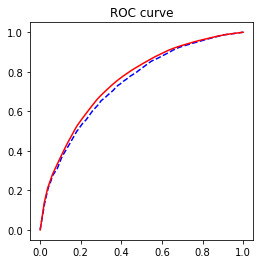

0.7706014100668233
0.7576385376385376


In [199]:
#模型表现比之前要好

fpr_test, tpr_test, th_test = roc_curve(test.target_flag, test_p[:, 1])

fpr_train, tpr_train, th_train = roc_curve(train.target_flag, train_p[:, 1])

plt.figure(figsize=[4, 4])
plt.plot(fpr_test, tpr_test, 'b--')
plt.plot(fpr_train, tpr_train, 'r-')
plt.title('ROC curve')
plt.show()



#使用组合方法提高模型表现
from sklearn.ensemble import GradientBoostingClassifier

gbc = GradientBoostingClassifier()
gbc.fit(train.ix[:, 1:], train.target_flag)
gbc_train_p = gbc.predict_proba(train.ix[:, 1:])
gbc_test_p = gbc.predict_proba(test.ix[:, 1:])

print(roc_auc_score(train.target_flag, gbc_train_p[:, 1]))
print(roc_auc_score(test.target_flag, gbc_test_p[:, 1]))

#### 模型优化

- 对连续型变量进行离散化,对离散化的结果进行WOE编码

In [165]:
#将home_value的值分箱处理

combine=[train,test]
train['hv_brand']=pd.qcut(train['home_value'],5)
train[['hv_brand', 'target_flag']].groupby(['hv_brand'], as_index=False).mean().sort_values(by='hv_brand', ascending=True)

,hv_brand,target_flag
0,"(-0.001, 26753.4]",0.349000
1,"(26753.4, 165952.0]",0.353549
2,"(165952.0, 272009.0]",0.520920
3,"(272009.0, 456165.0]",0.605430
4,"(456165.0, 9999999.0]",0.670392


In [166]:
for dataset in combine:
    dataset.loc[dataset['home_value']<=26753.4,'home_value']=0
    dataset.loc[(dataset['home_value']>26753.4) & (dataset['home_value']<=165952.0),'home_value']=1
    dataset.loc[(dataset['home_value']>165952.0) & (dataset['home_value']<=272009.0),'home_value']=2
    dataset.loc[(dataset['home_value']>272009.0) & (dataset['home_value']<=456165.0),'home_value']=3
    dataset.loc[(dataset['home_value']>456165.0) & (dataset['home_value']<=9999999.0),'home_value']=4
    dataset['home_value']=dataset['home_value'].astype(int)
    
train=train.drop(['hv_brand'],axis=1)
combine = [train, test]
train.head(10)

,target_flag,gender,education,home_value,age,buy_online,mosaic_group,marital,occupation,new_car
0,1,0.388459,0.654383,4,-0.489924,-0.645624,0.496589,-0.423279,0.602608,1
1,0,-0.443879,0.513493,2,-0.670878,-0.645624,-0.018658,-0.423279,0.602608,3
2,0,0.388459,-0.028077,1,-0.740683,0.289713,0.755544,-0.423279,0.602608,1
3,1,0.388459,-0.028077,3,-0.740683,0.289713,0.496589,-0.169880,-0.249091,2
4,1,-0.443879,-0.028077,1,-0.489924,0.289713,-0.742657,0.321675,-0.249091,7
5,1,-0.443879,0.513493,2,0.224615,0.289713,0.496589,0.321675,0.602608,1
6,1,0.388459,0.513493,4,-0.489924,0.289713,0.367337,0.321675,0.602608,5
7,0,-0.443879,0.513493,3,0.508850,0.289713,0.755544,0.321675,0.602608,2
8,0,-0.443879,-0.569207,2,0.396473,0.289713,-0.766360,-0.423279,-0.395345,5
9,1,0.388459,-0.569207,2,-0.489924,0.289713,0.755544,0.321675,-0.249091,6


In [168]:
from woe import WoE

for col in x_c:
    woe=WoE(v_type='d',t_type='b')
    woe.fit(train[col],train.target_flag)
    train[col]=woe.transform(train[col])['woe']
    test[col]=woe.transform(test[col])['woe']

In [175]:
#对变量进行IV值得筛选


cols = set(train.columns.tolist())-set(['target_flag'])
iv_c = {}
for i in cols:
    iv_c[i] = WoE(v_type='d').fit(train[i],train['target_flag']).iv 
sort_iv_c = pd.Series(iv_c).sort_values(ascending=False)
sort_iv_c

mosaic_group    0.331782
home_value      0.280271
education       0.274997
new_car         0.271476
occupation      0.241121
age             0.209137
gender          0.193129
buy_online      0.184189
marital         0.119084
dtype: float64

In [176]:
#建模

cv.fit(train.ix[:,1:],train['target_flag'])
print('best_score:%2.4f'  %cv.best_score_)
print('best_params: %s' %cv.best_params_)

best_score:0.7400
best_params: {'max_leaf_nodes': 62, 'min_samples_split': 150}


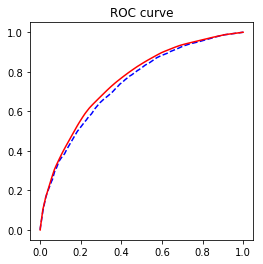

In [180]:


#模型评估（模型的过拟合情况不太严重）
train_p = cv.predict_proba(train.ix[:, 1:])
test_p = cv.predict_proba(test.ix[:, 1:])
fpr_test, tpr_test, th_test = roc_curve(test.target_flag, test_p[:, 1])

fpr_train, tpr_train, th_train = roc_curve(train.target_flag, train_p[:, 1])

plt.figure(figsize=[4, 4])
plt.plot(fpr_test, tpr_test, 'b--')
plt.plot(fpr_train, tpr_train, 'r-')
plt.title('ROC curve')
plt.show()

In [181]:
imp = cv.best_estimator_.feature_importances_
list(zip(train.ix[:, 1:].columns, imp))

[('gender', 0.1772414039593889),
 ('education', 0.10358755942305849),
 ('home_value', 0.04165321068771178),
 ('age', 0.115118248740859),
 ('buy_online', 0.08317584453841767),
 ('mosaic_group', 0.3391510453998626),
 ('marital', 0.03299929124604115),
 ('occupation', 0.0797381605289854),
 ('new_car', 0.027335235475675127)]

In [182]:
#使用组合方法提高模型表现（测试集得分数相较优化前有显著提升）
from sklearn.ensemble import GradientBoostingClassifier

gbc = GradientBoostingClassifier()
gbc.fit(train.ix[:, 1:], train.target_flag)
gbc_train_p = gbc.predict_proba(train.ix[:, 1:])
gbc_test_p = gbc.predict_proba(test.ix[:, 1:])

print(roc_auc_score(train.target_flag, gbc_train_p[:, 1]))
print(roc_auc_score(test.target_flag, gbc_test_p[:, 1]))

0.7694442343826927
0.7582216582216581


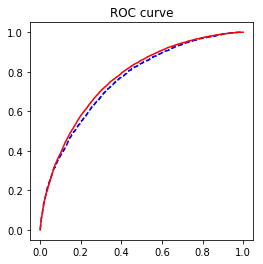

In [200]:
train_p = gbc.predict_proba(train.ix[:, 1:])
test_p = gbc.predict_proba(test.ix[:, 1:])
fpr_test, tpr_test, th_test = roc_curve(test.target_flag, test_p[:, 1])

fpr_train, tpr_train, th_train = roc_curve(train.target_flag, train_p[:, 1])

plt.figure(figsize=[4, 4])
plt.plot(fpr_test, tpr_test, 'b--')
plt.plot(fpr_train, tpr_train, 'r-')
plt.title('ROC curve')
plt.show()